<a href="https://colab.research.google.com/github/artemisyang/LS_assignment1_Artemis/blob/master/Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Note: To save credits for Midway RCC, I ran all of my GPU programs directly in Google Colab instead of on Midway.

In [2]:
! pip install pyopencl mako
! pip install mpi4py

import pyopencl as cl
import numpy as np
import pyopencl.array as cl_array
import pyopencl.clrandom as clrand
import pyopencl.tools as cltools
from pyopencl.scan import GenericScanKernel
from pyopencl.elementwise import ElementwiseKernel
import queue
import time
import scipy.stats as sts
import pandas as pd
from google.colab import files
import matplotlib.pyplot as plt
from mpi4py import MPI
from scipy.optimize import minimize

1.(a) The code from files that I ran on Midway RCC are attached. The plot is for 1-100 CPU cores.

In [0]:
# 1.(a) code from q1.sbatch file:
#!/bin/bash

#SBATCH --job-name=q1
#SBATCH --partition=broadwl
#SBATCH --constraint=fdr
#SBATCH --ntasks=150
#SBATCH --output=q1.out

# Load the default mpi4py/Anaconda module.
 module load mpi4py/3.0.1a0_py3
 
# Run the python program with mpirun, using & to run jobs at the same time
  for i in {1..100}
  do
    mpirun -n $i python ./health_index.py
  done

In [0]:
# 1.(a) code from health_index.py file

def sim_health_index():

    # Get rank of process and overall size of communicator:
    comm = MPI.COMM_WORLD
    rank = comm.Get_rank()
    size = comm.Get_size()
    
    # Start time:
    t0 = time.time()
   
    # Set model parameters
    rho = 0.5
    mu = 3.0
    sigma = 1.0
    z_0 = mu

    # Set simulation parameters
    S = 1000 # Set the number of lives to simulate
    T = int(4160) # Set the number of periods for each simulation

    # Evenly distribute number of simulation runs across processes
    N = int(S/size)

    # Draw all idiosyncratic random shocks and create empty containers
    np.random.seed(25)
    eps_mat = sts.norm.rvs(loc=0, scale=sigma, size=(T, N))
    z_mat = np.zeros((T, N))
    z_mat[0, :] = z_0

    for s_ind in range(N):
        z_tm1 = z_0
        for t_ind in range(T):
            e_t = eps_mat[t_ind, s_ind]
            z_t = rho * z_tm1 + (1 - rho) * mu + e_t
            z_mat[t_ind, s_ind] = z_t
            z_tm1 = z_t

  # Gather all simulation arrays to buffer on rank 0
    z_mat_all = None
    if rank == 0:
       z_mat_all = np.empty([T, int(N*size)], dtype = 'float')
    comm.Gather(sendbuf=z_mat, recvbuf=z_mat_all, root=0)
    #comm.gather(z_mat, root=0)
     
  # Print simulation results on rank 0
    if rank == 0:
     # Calculate time elapsed
       time_elapsed = time.time() - t0
     # Print(time_elapsed)
       print("Simulated lifetimes in: %f seconds on %d MPI processes"
                % (time_elapsed, size))     
   
    return

def main():
    sim_health_index()

if __name__ == '__main__':
    main()

Saving q1.csv to q1 (15).csv


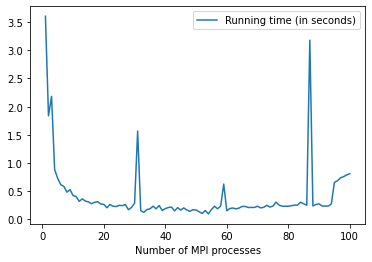

In [0]:
# 1.(a) plot
uploaded = files.upload()
df = pd.read_csv("q1.csv", names=["Number of MPI processes", "Running time (in seconds)"])
df.plot(x="Number of MPI processes",y="Running time (in seconds)")

1.(b) One reason that the speedup is not linear is the communication workload. In this task, we split the 1000 simulations evenly across processors, and we always need to send processed simulation results back to one MPI processor (with rank of 0). As we increase the number of processors, the communication step could take more time. Also, the running time of matrix operations highly depends on CPU cache memory size. Thus increasing number of processors does not necessarily decrease the overall running time.

2.(a) Using the elementwise kernel, it takes 0.47 second to run. Using the scan kernel, it takes 0.51 second to run. As there is some unknown calculation error in the scan kernel and it doesn't return the correct values, I choose to use the elementwise kernel.

In [0]:
#2.(a) with elementwise kernel

def sim_health_index():

  # Set up context and command queue
  ctx = cl.create_some_context()
  queue = cl.CommandQueue(ctx)
    
  # Start time:
  t0 = time.time()
   
  # Set model parameters
  S = 1000 # Set the number of lives to simulate
  T = int(4160) # Set the number of periods for each simulation
  rho = 0.5
  mu = 3.0
  np.random.seed(25)
  z_mat = np.zeros((T, S), dtype=np.float32)
  
  # Generate array of random shocks
  init_np = np.zeros(S).astype(np.float32) + mu
  epsm_np = sts.norm.rvs(loc=0,scale=1.0,size=T*S).astype(np.float32)

  init_g = cl.array.to_device(queue, init_np)
  epsm_g = cl.array.to_device(queue, epsm_np)
  
  # GPU: Define Elementwise Kernel
  prefix_sum = ElementwiseKernel(ctx,
               "float *a_g, float *b_g, float *res_g, float rho, float mu",
               "res_g[i] = rho * a_g[i]+(1-rho)*mu + b_g[i]")
  
  # Allocate space for result of kernel on device
  dev_result = cl_array.empty_like(epsm_g)

  # Enqueue and Run Elementwise Kernel
  prefix_sum(init_g, epsm_g[:S], dev_result[:S], rho, mu)
  [prefix_sum(dev_result[S*(i-1):S*i], epsm_g[S*i:S*(i+1)],
              dev_result[S*i:S*(i+1)], rho, mu) for i in range(1,T)]

  # Get results back on CPU
  z_all = dev_result.get().reshape(T,S)

# Print simulation results
  print(z_all)

  final_time = time.time()
  time_elapsed = final_time - t0
  print("Simulated %d lifetimes in: %f seconds"
               % (S, time_elapsed)) 

  return

def main():
    sim_health_index()

if __name__ == '__main__':
    main()

[[3.2282732  4.0268903  2.1604152  ... 3.5980616  4.2172623  4.2740126 ]
 [2.7241552  2.7610037  1.8453364  ... 4.562945   4.1576777  2.4020617 ]
 [0.88323987 3.602325   1.863601   ... 3.6887615  3.2543025  3.5586102 ]
 ...
 [5.7436695  2.7490346  3.707395   ... 1.8711723  1.6462877  2.4367635 ]
 [5.444686   3.167647   4.440064   ... 2.866872   3.2936373  2.6143126 ]
 [3.721859   4.119889   4.6702805  ... 2.063307   3.2129734  2.634847  ]]
Simulated 1000 lifetimes in: 0.469585 seconds


In [0]:
# 2.(a) with scan kernel

def sim_health_index():

  # Set up context and command queue
  ctx = cl.create_some_context()
  queue = cl.CommandQueue(ctx)
    
  # Start time:
  t0 = time.time()
   
  # Set model parameters
  S = 1000 # Set the number of lives to simulate
  T = int(4160) # Set the number of periods for each simulation
  np.random.seed(25)
  z_mat = np.zeros((T, S), dtype=np.float32)
  
  # Generate array of random shocks
  rand_gen = clrand.PhiloxGenerator(ctx)
  ran = rand_gen.normal(queue, (S*T), np.float32, mu=0, sigma=1)
  #print(ran)

  # Change the value for the first row to account for the initial value of z_t
  for z in range(S):
    z = z * T - T
    ran[z] = ran[z] + 3
  
  # Establish boundaries for each simulated 
  seg_boundaries = [1] + [0] * (T - 1) 
  seg_boundaries = np.array(seg_boundaries, dtype=np.uint8)
  #print(seg_boundaries)
  seg_boundary_flags = np.tile(seg_boundaries, int(S))
  seg_boundary_flags = cl_array.to_device(queue, seg_boundary_flags)
  #print(seg_boundary_flags)
  
  # GPU: Define Segmented Scan Kernel
  prefix_sum = GenericScanKernel(ctx, np.float32,
               arguments="__global float *ary, __global char *segflags, "
                   "__global float *out",
               input_expr="ary[i]",
               scan_expr="across_seg_boundary ? b : (b+a*0.5+1.5)", neutral="0",
               is_segment_start_expr="segflags[i]",
               output_statement="out[i] = item",
               options=[])
  
  # Allocate space for result of kernel on device
  dev_result = cl_array.empty_like(ran)

  # Enqueue and Run Scan Kernel
  prefix_sum(ran, seg_boundary_flags, dev_result)

  # Get results back on CPU
  z_all = (dev_result.get()
                     .reshape(S, T)
                     .transpose()
                         )

# Print simulation results
  print(z_all)

  final_time = time.time()
  time_elapsed = final_time - t0
  print("Simulated %d lifetimes in: %f seconds"
                % (S, time_elapsed)) 
  return

def main():
    sim_health_index()

if __name__ == '__main__':
    main()

[[ 3.305101   1.7843852  2.310944  ...  2.7387207  3.339977   4.77309  ]
 [ 2.7882876  3.432971   3.084823  ...  2.5825524  2.555361   1.7009106]
 [ 2.7027223  2.7213817  2.396581  ...  1.3811734  2.4580746  1.0173331]
 ...
 [55.12113    8.4563675 56.63877   ... 55.94834   44.431953  55.21933  ]
 [56.071236   8.27284   57.71346   ... 55.7464    44.292847  53.851566 ]
 [55.363197   8.4304    57.280464  ... 56.229134  43.877567  51.959373 ]]
Simulated 1000 lifetimes in: 0.511954 seconds


2.(b) When the number of processors is small (less than 4) in the MPI implementation, the PyOpenCL implementation is obviously faster. When the number of processors is bigger than 10 in the MPI implementation, the running time is usually lower than 0.5 second except for a few outliers, so the PyOpenCL implementation costs a little bit more time, but it's almost a negligible amount of time for this particular task. Also the running time of PyOpenCL seems more stable. The PyOpenCL implementation performs well for this task because GPU contains sets of cores working on same instruction in a lock-step fashion for the purpose of parallelisim. Compared with parallelisim through multiple CPU cores, the GPU has the advantage that it does not need extra time for communication. Plus, our task does not require a big amount of global memory, so it works well with the GPU.

3.(a) With the MPI implementation, the running time is 1290.3 seconds. Here is the printed message copied from the .out file: "Simulated in 1290.298222 seconds, Optimal rho value = -0.052513, Average periods = 764.991000". The code files are attached:

In [0]:
# 3.(a) code from q3a.sbatch file
#!/bin/bash

#SBATCH --job-name=q3
#SBATCH --partition=broadwl
#SBATCH --constraint=fdr
#SBATCH --mem-per-cpu=2G
#SBATCH --account=macs30123
#SBATCH --output=q3a.out

# Load the default mpi4py/Anaconda module.
 module load mpi4py/3.0.1a0_py3
 
# Run the python program with mpirun, using & to run jobs at the same time
 
 mpirun -n 20 python ./q3a.py

In [0]:
# 3.(a) code from q3a.py file
    
def sim_health_index():

    t0 = time.time()
    rho_array = np.linspace(-0.95,0.95,200)
    avg =[]
    
    for r in rho_array:
    
        # Get rank of process and overall size of communicator:
        comm = MPI.COMM_WORLD
        rank = comm.Get_rank()
        size = comm.Get_size()
   
        # Set model parameters
        rho = r
        mu = 3.0
        sigma = 1.0
        z_0 = mu

        # Set simulation parameters
        S = 1000 # Set the number of lives to simulate
        T = int(4160) # Set the number of periods for each simulation

        # Evenly distribute number of simulation runs across processes
        N = int(S/size)

        # Draw all idiosyncratic random shocks and create empty containers
        eps_mat = sts.norm.rvs(loc=0, scale=sigma, size=(T, N))
        z_mat = np.zeros((T, N))
        z_mat[0, :] = z_0
    
        # Create an array to store the index for first negative z_t
        neg_index = np.full(N,fill_value = T+1)

        # Create the health index matrix
        for s_ind in range(N):
            z_tm1 = z_0
            for t_ind in range(T):
                e_t = eps_mat[t_ind, s_ind]
                z_t = rho * z_tm1 + (1 - rho) * mu + e_t
                z_mat[t_ind, s_ind] = z_t
                z_tm1 = z_t
                if z_tm1<0:
                  if neg_index[s_ind] == T+1:
                     neg_index[s_ind] = t_ind+1

        # Gather all simulation arrays to buffer on rank 0
        neg_all = comm.gather(neg_index, root = 0)
     
        # Return average number of periods on rank 0
        if rank == 0:
           mean = np.mean(neg_all)
           avg.append(mean)
           
    if rank == 0:
        
       # Get optimal rho value
       ind = avg.index(max(avg))
       opt = rho_array[ind]
       max_avg = max(avg)

       # Print simulation results
       time_elapsed = time.time() - t0
       print("Simulated in %f seconds, Optimal rho value = %f, Average periods = %f"
                % (time_elapsed, opt, max_avg)) 
       print(rho_array)
       print(avg)

def main():
   sim_health_index()
          
if __name__ == '__main__':
    main()

3.(b) 
Using OpenCL to run the same program, the optimal $\rho$ value is 0.033417 and the average number of periods is 755.71. The computation time becomes 1540 seconds. The MPI implementation is faster for this task, because the grid search process needs to loop over 200 times of the simulations, which is very time-consuming. Dividing the simulations into parallel tasks among 20 MPI processors could save some computation time.

Simulated in 1539.689966 seconds, Optimal rho value = 0.033417, Average periods = 755.710000


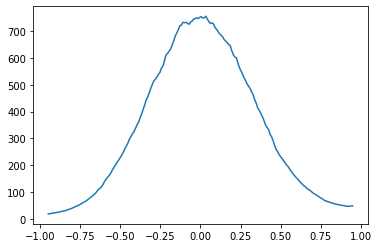

In [0]:
# 3.(b) grid search with OpenCL

def sim_health_index(r):

  # Set up context and command queue
  ctx = cl.create_some_context()
  queue = cl.CommandQueue(ctx)
    
  # Start time:
  t0 = time.time()
   
  # Set model parameters
  S = 1000 # Set the number of lives to simulate
  T = int(4160) # Set the number of periods for each simulation
  rho = r
  mu = 3.0
  np.random.seed(25)
  z_mat = np.zeros((T, S), dtype=np.float32)
  
  # Generate array of random shocks
  init_np = np.zeros(S).astype(np.float32) + mu
  epsm_np = sts.norm.rvs(loc=0,scale=1.0,size=T*S).astype(np.float32)

  init_g = cl.array.to_device(queue, init_np)
  epsm_g = cl.array.to_device(queue, epsm_np)
  
  # GPU: Define Segmented Elementwise Kernel
  prefix_sum = ElementwiseKernel(ctx,
               "float *a_g, float *b_g, float *res_g, float rho, float mu",
               "res_g[i] = rho * a_g[i]+(1-rho)*mu + b_g[i]")
  
  # Allocate space for result of kernel on device
  dev_result = cl_array.empty_like(epsm_g)

  # Enqueue and Run Elementwise Kernel
  prefix_sum(init_g, epsm_g[:S], dev_result[:S], rho, mu)
  [prefix_sum(dev_result[S*(i-1):S*i], epsm_g[S*i:S*(i+1)],
              dev_result[S*i:S*(i+1)], rho, mu) for i in range(1,T)]

  # Get results back on CPU
  z_all = dev_result.get().reshape(T,S)

  # Create an array to store the index for first negative z_t
  neg_index = np.full(S,fill_value = T+1)

  # Print simulation results
  for s in range(S):
    for t in range(T):
      if z_all[t,s] < 0:
        if neg_index[s] == T+1:
           neg_index[s] = t+1
  return np.mean(neg_index)

def main():
    # Start time
    t0 = time.time()
    
    # Run the health simulation program
    rho_array = np.linspace(-0.95,0.95,200)
    avg =np.zeros(200)
    
    # run program with different rhos
    for r in range(len(rho_array)):
        avg[r] = sim_health_index(rho_array[r])
    
    # Get optimal rho value and index
    max_avg = np.amax(avg)
    opt = rho_array[np.argmax(avg)] 

    # End time
    time_elapsed = time.time() - t0

    # Print simulation results
    print("Simulated in %f seconds, Optimal rho value = %f, Average periods = %f"
                % (time_elapsed, opt, max_avg)) 
    plt.plot(rho_array,avg)
  
if __name__ == '__main__':
    main()

3.(c) Below is the plot using results from the MPI implementation. The plot indicates that rho values close to 0 tend to have larger average periods to negative health index, which is very similar to the plot created from the OpenCL implementation from last question.

Saving q3c.csv to q3c (1).csv


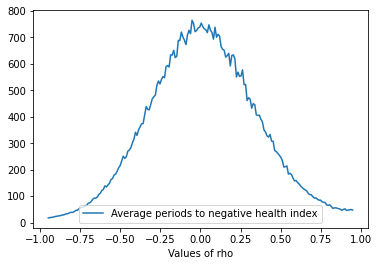

In [0]:
# 3.(c) plot
uploaded = files.upload()
df2 = pd.read_csv("q3c.csv", names=["Values of rho", "Average periods to negative health index"])
df2.plot(x="Values of rho",y="Average periods to negative health index")

3.(d) From the MPI implementation in 3(a), the optimal $\rho$ value is -0.052513, and the corresponding average periods is 764.991. From the GPU implementation in 3(b), the optimal $\rho$ value is 0.033417, and the corresponding average periods is 755.71. The results are different but very close.

4.(a) The computation time is 499.4 seconds with the MPI implementation.

In [4]:
# 4.(a) 

comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()

t0 = time.time()

mu = 3.0
sigma = 1.0
z_0 = mu
S = 1000 # Set the number of lives to simulate
T = int(4160) # Set the number of periods for each simulation

# Evenly distribute number of simulation runs across processes
N = int(S/size)

def parallel_function_caller(x,stopp):
    stopp[0]=comm.bcast(stopp[0], root=0)
    summ=0
    if stopp[0]==0:
        #your function here in parallel
        x=comm.bcast(x, root=0)
        #Create an array to store the index for first negative z_t
        neg_index = np.full(N,fill_value = T+1)
        # Draw all idiosyncratic random shocks and create empty containers
        np.random.seed(25)
        eps_mat = sts.norm.rvs(loc=0, scale=sigma, size=(T, N))
        z_mat = np.zeros((T, N))
        for s_ind in range(N):
            z_tm1 = z_0
            for t_ind in range(T):
                e_t = eps_mat[t_ind, s_ind]
                z_t = x[0] * z_tm1 + (1 - x[0]) * mu + e_t
                z_mat[t_ind, s_ind] = z_t
                z_tm1 = z_t
                if z_tm1<0:
                  if neg_index[s_ind] == T+1:
                     neg_index[s_ind] = t_ind+1 
        neg_all = comm.gather(neg_index, root = 0)  
        summl=np.max(np.mean(neg_all)) 
        summ=comm.reduce(summl,op=MPI.SUM, root=0)
        if rank==0:
          print("rho value is "+str(x)+", average periods is "+str(summ))
    return -summ

if rank == 0 :
   stop=[0]
   x = np.zeros(1)
   x[0]=0.1
   xs = minimize(parallel_function_caller,x0 = x, args=(stop,), 
                 method = 'L-BFGS-B', bounds = ((-0.95,0.95),), 
                 options = {'eps' : 0.2})   #method = 'COBYLA'
   print("the argmin is "+str(xs))
   stop=[1]
   parallel_function_caller(x,stop)
   
   time_elapsed = time.time() - t0
   print("Simulated in %f seconds" % (time_elapsed)) 

else :
   stop=[0]
   x=np.zeros(1)
   while stop[0]==0:
      parallel_function_caller(x,stop)

rho value is [0.1], average periods is 707.526
rho value is [0.3], average periods is 495.326
rho value is [-0.95], average periods is 18.534
rho value is [-0.75], average periods is 54.116
rho value is [-0.06389874], average periods is 734.254
rho value is [0.13610126], average periods is 679.333
rho value is [-0.12113132], average periods is 720.269
rho value is [0.07886868], average periods is 729.871
rho value is [-0.07104007], average periods is 727.086
rho value is [0.12895993], average periods is 685.278
rho value is [-0.06416901], average periods is 734.254
rho value is [0.13583099], average periods is 679.333
rho value is [-0.06395578], average periods is 734.254
rho value is [0.13604422], average periods is 679.333
rho value is [-0.06391078], average periods is 734.254
rho value is [0.13608922], average periods is 679.333
rho value is [-0.06390128], average periods is 734.254
rho value is [0.13609872], average periods is 679.333
rho value is [-0.06389928], average periods is 

4.(b) The computation time using OpenCL is 624.5 seconds. 

In [3]:
# 4.(b)

ctx = cl.create_some_context()
queue = cl.CommandQueue(ctx)

t0 = time.time()

mu = 3.0
sigma = 1.0
z_0 = mu
S = 1000 # Set the number of lives to simulate
T = int(4160) # Set the number of periods for each simulation

def parallel_function_caller(x,stopp):
    #your function here in parallel
    z_mat = np.zeros((T, S), dtype=np.float32)
    # Generate array of random shocks
    np.random.seed(25)
    init_np = np.zeros(S).astype(np.float32) + mu
    epsm_np = sts.norm.rvs(loc=0,scale=1.0,size=T*S).astype(np.float32)
    init_g = cl.array.to_device(queue, init_np)
    epsm_g = cl.array.to_device(queue, epsm_np)
    # GPU: Define Segmented Elementwise Kernel
    prefix_sum = ElementwiseKernel(ctx,
               "float *a_g, float *b_g, float *res_g, float x, float mu",
               "res_g[i] = x * a_g[i]+(1-x)*mu + b_g[i]")
    # Allocate space for result of kernel on device
    dev_result = cl_array.empty_like(epsm_g)
    # Enqueue and Run Elementwise Kernel
    prefix_sum(init_g, epsm_g[:S], dev_result[:S], x, mu)
    [prefix_sum(dev_result[S*(i-1):S*i], epsm_g[S*i:S*(i+1)],
          dev_result[S*i:S*(i+1)], x, mu) for i in range(1,T)]
    # Get results back on CPU
    z_all = dev_result.get().reshape(T,S)
    # Create an array to store the index for first negative z_t
    neg_index = np.full(S,fill_value = T+1)
    # Print simulation results
    for s in range(S):
        for t in range(T):
            if z_all[t,s] < 0:
               if neg_index[s] == T+1:
                  neg_index[s] = t+1
    print("rho value is "+str(x)+", average periods is "+str(np.mean(neg_index)))
    return -np.mean(neg_index)

stop=[0]
x = np.zeros(1)
x[0]=0.1
xs = minimize(parallel_function_caller,x0 = x, args=(stop,), 
                 method = 'L-BFGS-B', bounds = ((-0.95,0.95),), 
                 options = {'eps' : 0.2}) #method = 'COBYLA'
print(str(xs))
stop=[1]
parallel_function_caller(x,stop)

time_elapsed = time.time() - t0
print("Simulated in %f seconds" % (time_elapsed))

rho value is [0.1], average periods is 707.526
rho value is [0.3], average periods is 495.326
rho value is [-0.95], average periods is 18.534
rho value is [-0.75], average periods is 54.116
rho value is [-0.06389874], average periods is 734.254
rho value is [0.13610126], average periods is 679.333
rho value is [-0.12113132], average periods is 720.269
rho value is [0.07886868], average periods is 729.871
rho value is [-0.07104007], average periods is 727.086
rho value is [0.12895993], average periods is 685.278
rho value is [-0.06416901], average periods is 734.254
rho value is [0.13583099], average periods is 679.333
rho value is [-0.06395578], average periods is 734.254
rho value is [0.13604422], average periods is 679.333
rho value is [-0.06391078], average periods is 734.254
rho value is [0.13608922], average periods is 679.333
rho value is [-0.06390128], average periods is 734.254
rho value is [0.13609872], average periods is 679.333
rho value is [-0.06389928], average periods is 

4.(c) With the same random seed, the results from the MPI and the OpenCL implementations are the same: the optimal rho value is -0.06389874, and the corresponding average periods is 734.254.

4.(d) Compared with question 3, the computation in question 4 takes much less time. This method is faster than the grid search because it starts with a initial guess of the optimal value of $\rho$. This minimizer method no longer needs to loop over all 200 values of $\rho$, so it is able to find the optimal $\rho$ with running far less than 200 times of the same type of 1000 simulations.